In [1]:
import numpy as np
import cmocean.cm as cmo
import matplotlib.pyplot as plt
import xarray as xr
import xgcm
import gsw
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec

In [2]:
def fix_dimension(ds, bad_dim, new_dim, trim=True):
    assert len(ds[bad_dim]) == (len(ds[new_dim]) + 1)
    if trim and (len(ds[bad_dim]) == (len(ds[new_dim]) + 1)):
        ds = ds.isel(**{bad_dim: slice(0,-1)})
        assert len(ds[bad_dim]) == len(ds[new_dim])
    swapped_vars = []
    for v in ds:
        # replace naughty dimension
        dims = list(ds[v].dims)
        if bad_dim in dims:
            idx = dims.index(bad_dim)
            dims[idx] = new_dim
            ds[v].variable.dims = dims
            swapped_vars.append(v)
    return ds, swapped_vars

def reset_dimensions(ds, orig_dim, new_dim, *reset_vars):
    for v in reset_vars:
        dims = list(ds[v].dims)
        if new_dim in dims:
            idx = dims.index(new_dim)
            dims[idx] = orig_dim
            ds[v].variable.dims = dims
    # reindexing necessary to figure out new dims
    return ds.reindex()

def open_mncdataset(fname_base, ntiles_y, ntiles_x, iternum=None):
    if iternum is not None:
        itersuf = '.%010d' % iternum
    else:
        itersuf = ''
    dsets_y = []
    for ny in range(ntiles_y):
        dsets_x = []
        swap_vars = set()
        for nx in range(ntiles_x):
            ntile = nx + ntiles_x*ny + 1
            fname = fname_base + '%s.t%03d.nc' % (itersuf, ntile)
            ds = xr.open_dataset(fname)
            ds, swapped_vars_x = fix_dimension(ds, 'Xp1', 'X')    
            ds = ds.chunk()
            dsets_x.append(ds)
        ds_xconcat = xr.concat(dsets_x, 'X')
        ds_xconcat, swapped_vars_y = fix_dimension(ds_xconcat, 'Yp1', 'Y')
        dsets_y.append(ds_xconcat)
    ds = xr.concat(dsets_y, 'Y')
    ds = reset_dimensions(ds, 'Xp1', 'X', *swapped_vars_x)
    ds = reset_dimensions(ds, 'Yp1', 'Y', *swapped_vars_y)
    return ds



In [4]:
dss = open_mncdataset('run_bump_barotrop/state', 2, 3, 0)
dsg = open_mncdataset('run_bump_barotrop/grid', 2, 3, None)
dsbb=xr.merge((dss,dsg))
dsbb=dsbb.isel(Zp1=slice(0,-1))
dsbb=dsbb.rename_dims({'Xp1':'X_left','Yp1':'Y_left','Zp1':'Z_left'})
dsbb = xgcm.generate_grid_ds(dsbb, {'X':'X', 'Y':'Y', 'Z':'Z'})
dsbb.coords['day']=dsbb.T/(24*3600)

dss = open_mncdataset('run_bump_20layers/state', 2, 3, 0)
dsg = open_mncdataset('run_bump_20layers/grid', 2, 3, None)
dsb2=xr.merge((dss,dsg))
dsb2=dsb2.isel(Zp1=slice(0,-1))
dsb2=dsb2.rename_dims({'Xp1':'X_left','Yp1':'Y_left','Zp1':'Z_left'})
dsb2 = xgcm.generate_grid_ds(dsb2, {'X':'X', 'Y':'Y', 'Z':'Z'})
dsb2.coords['day']=dsb2.T/(24*3600)

dss = open_mncdataset('run_bump_20layerswdTdy_tw/state', 2, 3, 0)
dsg = open_mncdataset('run_bump_20layerswdTdy_tw/grid', 2, 3, None)
dsb2t=xr.merge((dss,dsg))
dsb2t=dsb2t.isel(Zp1=slice(0,-1))
dsb2t=dsb2t.rename_dims({'Xp1':'X_left','Yp1':'Y_left','Zp1':'Z_left'})
dsb2t = xgcm.generate_grid_ds(dsb2t, {'X':'X', 'Y':'Y', 'Z':'Z'})
dsb2t.coords['day']=dsb2t.T/(24*3600)

dss = open_mncdataset('run_bump_tw/state', 2, 3, 0)
dsg = open_mncdataset('run_bump_tw/grid', 2, 3, None)
dsbt=xr.merge((dss,dsg))
dsbt=dsbt.isel(Zp1=slice(0,-1))
dsbt=dsbt.rename_dims({'Xp1':'X_left','Yp1':'Y_left','Zp1':'Z_left'})
dsbt=xgcm.generate_grid_ds(dsbt, {'X':'X', 'Y':'Y', 'Z':'Z'})
dsbt.coords['day']=dsbt.T/(24*3600)

dss = open_mncdataset('run_bump_tw_slip/state', 2, 3, 0)
dsg = open_mncdataset('run_bump_tw_slip/grid', 2, 3, None)
dsbts=xr.merge((dss,dsg))
dsbts=dsbts.isel(Zp1=slice(0,-1))
dsbts=dsbts.rename_dims({'Xp1':'X_left','Yp1':'Y_left','Zp1':'Z_left'})
dsbts=xgcm.generate_grid_ds(dsbts, {'X':'X', 'Y':'Y', 'Z':'Z'})
dsbts.coords['day']=dsbts.T/(24*3600)

dss = open_mncdataset('run_flat_tw/state', 2, 3, 0)
dsg = open_mncdataset('run_flat_tw/grid', 2, 3, None)
dsft=xr.merge((dss,dsg))
dsft=dsft.isel(Zp1=slice(0,-1))
dsft=dsft.rename_dims({'Xp1':'X_left','Yp1':'Y_left','Zp1':'Z_left'})
dsft=xgcm.generate_grid_ds(dsft, {'X':'X', 'Y':'Y', 'Z':'Z'})
dsft.coords['day']=dsft.T/(24*3600)

In [5]:
dsbb['drU']=dsbb.U.isel(T=0)*0+dsbb.drF.isel(X=30,Y=20)
dsbb['drV']=dsbb.V.isel(T=0)*0+dsbb.drF.isel(X=30,Y=20)
metrics = {
    ('X',): ['dxC', 'dxG', 'dxV'], # X distances
    ('Y',): ['dyC', 'dyG', 'dyU'], # Y distances
    ('Z',): ['drC', 'drF', 'drU', 'drV'], # Z distances
    }
grid = xgcm.Grid(dsbb, periodic=False, metrics=metrics)

Text(0.5, 1.0, 'e-scale')

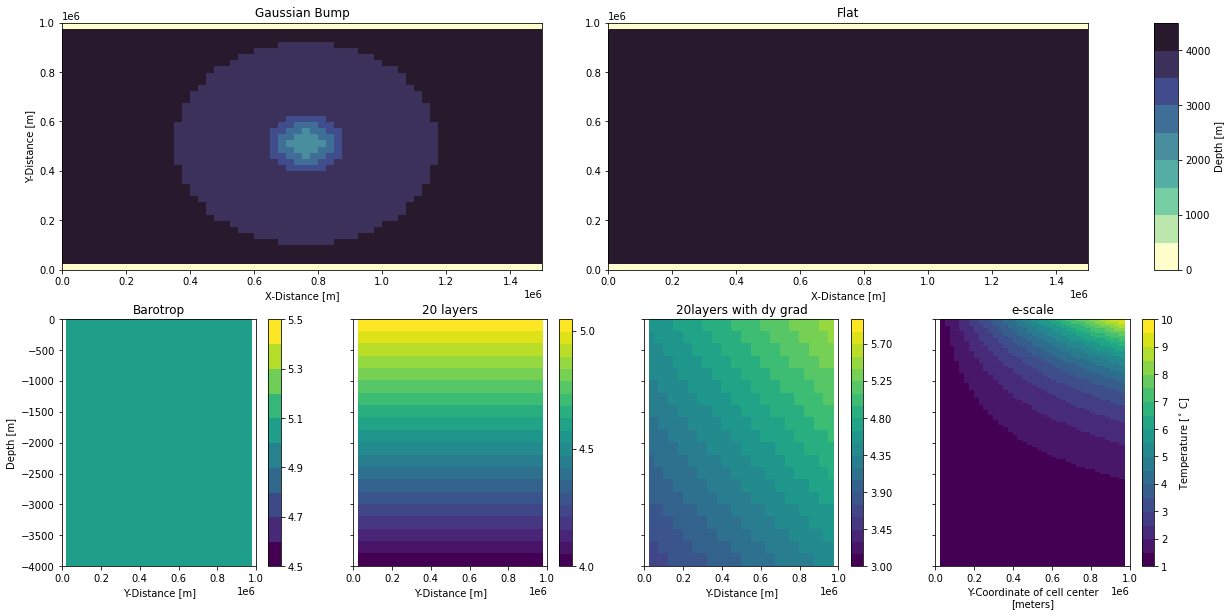

In [6]:
fig = plt.figure(figsize=(20,10))
gs = GridSpec(2,1, width_ratios=[1],wspace=.15)#,wspace=0.3)

gs1 = GridSpecFromSubplotSpec(1,3, subplot_spec=gs[0,0], width_ratios=[1,1,.05])
gs2 = GridSpecFromSubplotSpec(1,4, subplot_spec=gs[1,0], width_ratios=[1,1,1,1])

ax1 = fig.add_subplot(gs1[0])#,sharey=ttc_m12)
ax2 = fig.add_subplot(gs1[1])
cax_dep = fig.add_subplot(gs1[2])
ax3 = fig.add_subplot(gs2[0])#,sharey=ttc_m12)
ax4 = fig.add_subplot(gs2[1])
ax5 = fig.add_subplot(gs2[2])
ax6 = fig.add_subplot(gs2[3])
# Plot used bathymetries
dsbb.Depth.plot.pcolormesh(vmin=0,vmax=4500,levels=10,ax=ax1,cmap=cmo.deep,add_colorbar=False)
cb_dep=dsft.Depth.plot.pcolormesh(vmin=0,vmax=4500,levels=10,ax=ax2,cmap=cmo.deep,add_colorbar=False)
plt.colorbar(cb_dep,cax=cax_dep,label='Depth [m]', ticks=np.linspace(0,4000,5))
ax1.set_xlabel('X-Distance [m]')
ax1.set_ylabel('Y-Distance [m]')
ax1.set_title('Gaussian Bump')
ax2.set_xlabel('X-Distance [m]')
ax2.set_ylabel('')
ax2.set_title('Flat')

# Plot used temperature stratification
dsbb.Temp.where(dsbb.Temp>0).isel(X=10,T=0).plot.pcolormesh(vmin=4.5,vmax=5.5,levels=11,ax=ax3,cbar_kwargs={'label':''})#,add_colorbar=False)
dsb2.Temp.where(dsb2.Temp>0).isel(X=10,T=0).plot.pcolormesh(vmin=4.,vmax=5.05,levels=21,ax=ax4,cbar_kwargs={'label':'','ticks':np.linspace(4,5,3)})#,add_colorbar=False)ax=ax4)#,add_colorbar=False)
dsb2t.Temp.where(dsb2t.Temp>0).isel(X=10,T=0).plot.pcolormesh(vmin=3,vmax=6,levels=21,ax=ax5,cbar_kwargs={'label':''})#,add_colorbar=False)
dsbt.Temp.where(dsbt.Temp>0).isel(X=10,T=0).plot.pcolormesh(vmin=1,vmax=10,levels=19,ax=ax6,cbar_kwargs={'label':'Temperature [$^\circ\,$C]'})#,add_colorbar=False)
ax3.set_xlabel('Y-Distance [m]')
ax3.set_ylabel('Depth [m]')
#ax3.set_yticklabels('')
ax3.set_title('Barotrop')
ax4.set_xlabel('Y-Distance [m]')
ax4.set_ylabel('')
ax4.set_yticklabels('')
ax4.set_title('20 layers')
ax5.set_xlabel('Y-Distance [m]')
ax5.set_ylabel('')
ax5.set_yticklabels('')
ax5.set_title('20layers with dy grad')
ax6.set_ylabel('')
ax6.set_yticklabels('')
ax6.set_title('e-scale')
#plt.savefig('./figures/set_up.png',dpi=300)

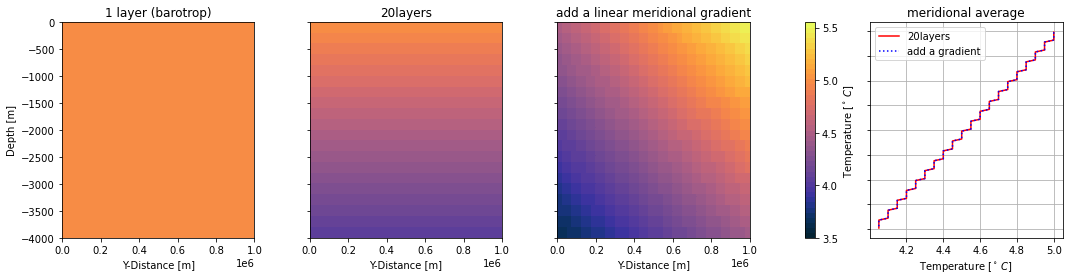

In [10]:
fig,axes=plt.subplots(1,5,figsize=(15,4),gridspec_kw={'width_ratios':[1,1,1,0.05,1]})

dsbb.Temp.isel(T=0,X=59).plot.pcolormesh(ax=axes[0],vmin=3.5,vmax=5.55, levels=43,cmap=cmo.thermal,add_colorbar=False)#,vmin=4.05,vmax=5.05,levels=22)          
axes[0].set_title('1 layer (barotrop)')
axes[0].set_ylabel('Depth [m]')
axes[0].set_xlabel('Y-Distance [m]')

dsb2.Temp.isel(T=0,X=59).plot.pcolormesh(ax=axes[1],vmin=3.5,vmax=5.55, levels=43,cmap=cmo.thermal,add_colorbar=False)#,vmin=4.05,vmax=5.05,levels=22)          
axes[1].set_title('20layers')
axes[1].set_ylabel('')
axes[1].set_yticklabels('')
axes[1].set_xlabel('Y-Distance [m]')
cb=dsb2t.Temp.isel(T=0,X=59).plot.pcolormesh(ax=axes[2],vmin=3.5,vmax=5.55,levels=43,cmap=cmo.thermal,add_colorbar=False)          
axes[2].set_title('add a linear meridional gradient')
axes[2].set_xlabel('Y-Distance [m]')
axes[2].set_ylabel('')
axes[2].set_yticklabels('')

plt.colorbar(cb,cax=axes[3],label='Temperature [$^\circ\,C$]',ticks=np.linspace(3.5,5.5,5))

dsb2.Temp.isel(T=0,X=59).mean(dim='Y').plot(y="Z",color='r',label='20layers',ax=axes[4])
dsb2t.Temp.isel(T=0,X=59).mean(dim='Y').plot(y="Z",color='b',ls=':',label='add a gradient',ax=axes[4])
axes[4].set_ylabel('')
axes[4].set_xlabel('Temperature [$^\circ\,C$]')
axes[4].set_yticklabels('')
axes[4].grid()
axes[4].legend()
axes[4].set_title('meridional average')
plt.tight_layout()

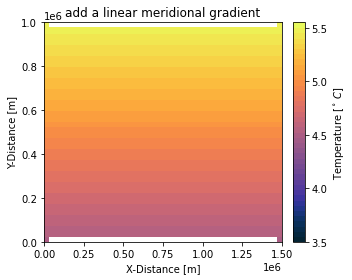

In [11]:
fig,axes=plt.subplots(1,2,figsize=(5,4),gridspec_kw={'width_ratios':[1,0.05]})
#
cb=dsb2t.Temp.where(dsb2t.Temp>0).isel(Z=0,T=0).plot.pcolormesh(ax=axes[0],vmin=3.5,vmax=5.55, levels=43,cmap=cmo.thermal,add_colorbar=False)
axes[0].set_title('add a linear meridional gradient')
axes[0].set_xlabel('X-Distance [m]')
axes[0].set_ylabel('Y-Distance [m]')


plt.colorbar(cb,cax=axes[1],label='Temperature [$^\circ\,C$]',ticks=np.linspace(3.5,5.5,5))
plt.tight_layout()

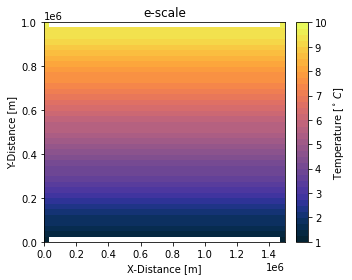

In [12]:
fig,axes=plt.subplots(1,2,figsize=(5,4),gridspec_kw={'width_ratios':[1,0.05]})
#
cb=dsbt.Temp.where(dsbt.Temp>0).isel(Z=0,T=0).plot.pcolormesh(ax=axes[0],vmin=1,vmax=10, levels=37,cmap=cmo.thermal,add_colorbar=False)
axes[0].set_title('e-scale')
axes[0].set_xlabel('X-Distance [m]')
axes[0].set_ylabel('Y-Distance [m]')


plt.colorbar(cb,cax=axes[1],label='Temperature [$^\circ\,C$]',ticks=np.linspace(1,10,10))
plt.tight_layout()

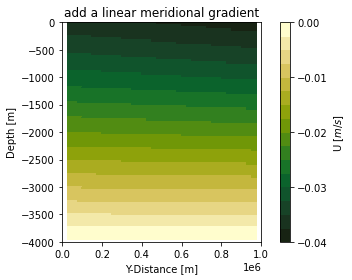

In [13]:
fig,axes=plt.subplots(1,2,figsize=(5,4),gridspec_kw={'width_ratios':[1,0.05]})
#
cb=dsb2t.U.isel(T=0,X_left=59).plot.pcolormesh(ax=axes[0],vmin=-.04,vmax=0,levels=17,cmap=cmo.speed_r,add_colorbar=False)          
axes[0].set_title('add a linear meridional gradient')
axes[0].set_xlabel('Y-Distance [m]')
axes[0].set_ylabel('Depth [m]')


plt.colorbar(cb,cax=axes[1],label='U [$m/s$]',ticks=np.linspace(-.04,0,5))
plt.tight_layout()

[Text(0, 0.0, ''),
 Text(0, 200000.0, ''),
 Text(0, 400000.0, ''),
 Text(0, 600000.0, ''),
 Text(0, 800000.0, ''),
 Text(0, 1000000.0, '')]

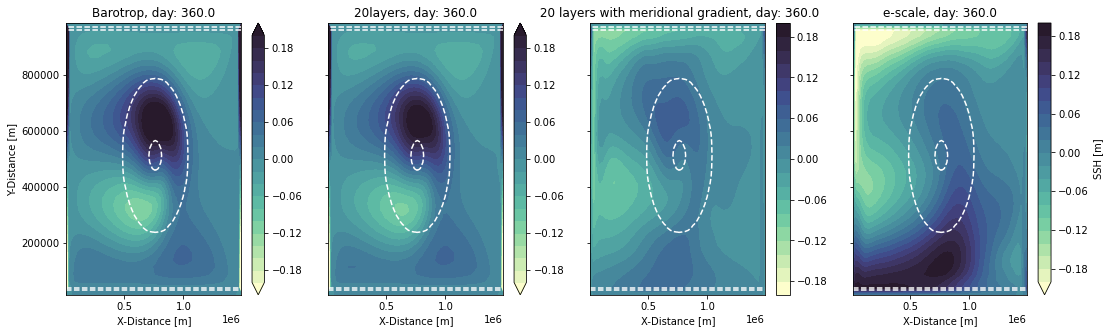

In [30]:
#plot SSH at last time step
t=12
arr=3
wmin=-.2
wmax=.2
cmap2=cmo.deep
lev=21

fig,axes=plt.subplots(1,4,figsize=(18,5))
ax=axes[0]
(dsbb.Eta.isel(T=t)-dsbb.Eta.isel(T=-1,X=58)).plot.contourf(cmap=cmap2,vmin=wmin,vmax=wmax,levels=lev,ax=ax,cbar_kwargs={'label':''})
dsbb.Depth.plot.contour(levels=[2500,3999],ax=ax,linestyles='--',colors='w')
ax.set_title(f'Barotrop, day: {dsbb.day.isel(T=t).values}')
ax.set_xlabel('X-Distance [m]')
ax.set_ylabel('Y-Distance [m]')

ax=axes[1]
(dsb2.Eta.isel(T=t)-dsb2.Eta.isel(T=-1,X=58)).plot.contourf(cmap=cmap2,vmin=wmin,vmax=wmax,levels=lev,ax=ax,cbar_kwargs={'label':''})
dsb2.Depth.plot.contour(levels=[2500,3999],ax=ax,linestyles='--',colors='w')
ax.set_title(f'20layers, day: {dsb2.day.isel(T=t).values}')
ax.set_xlabel('X-Distance [m]')
ax.set_ylabel('')
ax.set_yticklabels('')

ax=axes[2]
(dsb2t.Eta.isel(T=t)-dsb2t.Eta.isel(T=-1,X=58)).plot.contourf(cmap=cmap2,vmin=wmin,vmax=wmax,levels=lev,ax=ax,cbar_kwargs={'label':''})
dsb2t.Depth.plot.contour(levels=[2500,3999],ax=ax,linestyles='--',colors='w')
ax.set_title(f' 20 layers with meridional gradient, day: {dsbt.day.isel(T=t).values}')
ax.set_xlabel('X-Distance [m]')
ax.set_ylabel('')
ax.set_yticklabels('')

ax=axes[3]
(dsbt.Eta.isel(T=t)-dsbt.Eta.isel(T=-1,X=58)).plot.contourf(cmap=cmap2,vmin=wmin,vmax=wmax,levels=lev,ax=ax,cbar_kwargs={'label':'SSH [m]'})
dsbt.Depth.plot.contour(levels=[2500,3999],ax=ax,linestyles='--',colors='w')
ax.set_title(f'e-scale, day: {dsft.day.isel(T=t).values}')
ax.set_xlabel('X-Distance [m]')
ax.set_ylabel('')
ax.set_yticklabels('')


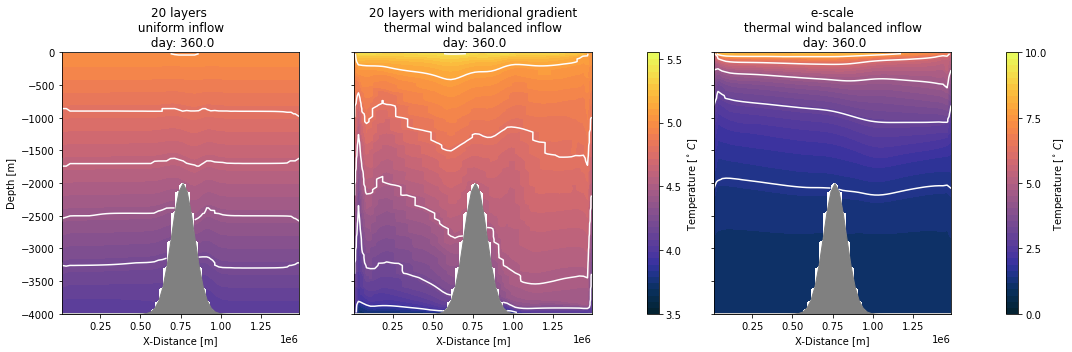

In [22]:
#plot SSH at last time step
t=12
arr=3
wmin=3.5
wmax=5.55
cmap2=cmo.thermal
lev=43

fig,axes=plt.subplots(1,5,figsize=(15,5),gridspec_kw={'width_ratios':[1,1,0.05,1,0.05]})


ax=axes[0]
dsb2.Temp.where(dsb2.Temp>0).isel(T=t,Y=20).plot.contourf(cmap=cmap2,vmin=wmin,vmax=wmax,levels=lev,ax=ax,add_colorbar=False)
ax.fill_between(dsb2.X,(-1*dsb2.Depth).isel(Y=20),-4000,color='grey')
dsb2.Temp.where(dsb2.Temp>0).isel(T=t,Y=20).plot.contour(ax=ax,colors='w')
ax.set_title(f'20 layers \n uniform inflow \n day: {dsb2.day.isel(T=t).values}')
ax.set_xlabel('X-Distance [m]')
ax.set_ylabel('Depth [m]')
ax.set_ylim((-4000,0))

ax=axes[1]
cb=(dsb2t.Temp.where(dsb2t.Temp>0).isel(T=t,Y=20)).plot.contourf(cmap=cmap2,vmin=wmin,vmax=wmax,levels=lev,ax=ax,add_colorbar=False)
dsb2t.Temp.where(dsb2t.Temp>0).isel(T=t,Y=20).plot.contour(ax=ax,colors='w')
ax.fill_between(dsbb.X,(-1*dsbb.Depth).isel(Y=20),-4000,color='grey')

ax.set_title(f' 20 layers with meridional gradient \n thermal wind balanced inflow \n day: {dsbb.day.isel(T=t).values}')
ax.set_xlabel('X-Distance [m]')
ax.set_ylabel('')
ax.set_ylim((-4000,0))
ax.set_yticklabels('')
plt.colorbar(cb,cax=axes[2],label='Temperature [$^\circ\,C$]',ticks=np.linspace(3.5,5.5,5))
ax=axes[3]
cb=(dsbt.Temp.where(dsbt.Temp>0).isel(T=t,Y=20)).plot.contourf(cmap=cmap2,vmin=0,vmax=10,levels=lev,ax=ax,add_colorbar=False)
dsbt.Temp.where(dsbt.Temp>0).isel(T=t,Y=20).plot.contour(ax=ax,colors='w')
ax.fill_between(dsbb.X,(-1*dsbb.Depth).isel(Y=20),-4000,color='grey')

ax.set_title(f' e-scale \n thermal wind balanced inflow \n day: {dsbt.day.isel(T=t).values}')
ax.set_xlabel('X-Distance [m]')
ax.set_ylabel('')
ax.set_ylim((-4000,0))
ax.set_yticklabels('')

plt.colorbar(cb,cax=axes[4],label='Temperature [$^\circ\,C$]',ticks=np.linspace(0,10,5))
plt.tight_layout()

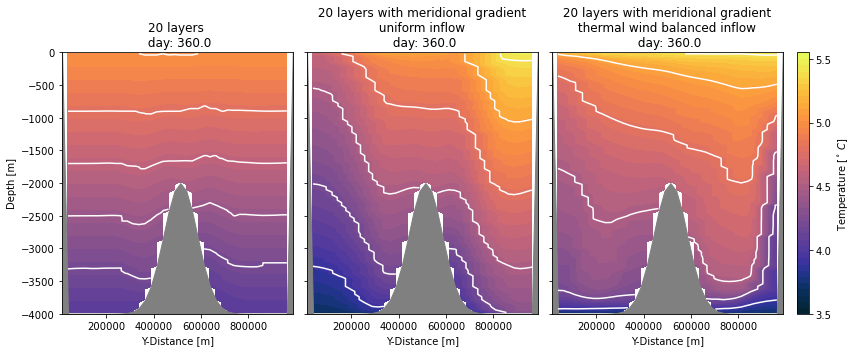

In [13]:
#plot SSH at last time step
t=12
arr=3
wmin=3.5
wmax=5.55
cmap2=cmo.thermal
lev=43

fig,axes=plt.subplots(1,4,figsize=(12,5),gridspec_kw={'width_ratios':[1,1,1,0.05]})


ax=axes[0]
dsb2.Temp.where(dsb2.Temp>0).isel(T=t,X=30).plot.contourf(cmap=cmap2,vmin=wmin,vmax=wmax,levels=lev,ax=ax,add_colorbar=False)
dsb2.Temp.where(dsb2.Temp>0).isel(T=t,X=30).plot.contour(ax=ax,colors='w')
ax.fill_between(dsb2.Y,(-1*dsb2.Depth).isel(X=30),-4000,color='grey')
ax.set_title(f'20 layers \n day: {dsb2.day.isel(T=t).values}')
ax.set_xlabel('Y-Distance [m]')
ax.set_ylabel('Depth [m]')
ax.set_ylim((-4000,0))

ax=axes[1]
dsb2u.Temp.where(dsb2u.Temp>0).isel(T=t,X=30).plot.contourf(cmap=cmap2,vmin=wmin,vmax=wmax,levels=lev,ax=ax,add_colorbar=False)
dsb2u.Temp.where(dsb2u.Temp>0).isel(T=t,X=30).plot.contour(ax=ax,colors='w')
ax.fill_between(dsb2u.Y,(-1*dsb2u.Depth).isel(X=30),-4000,color='grey')

ax.set_title(f' 20 layers with meridional gradient \n uniform inflow \n day: {dsb2u.day.isel(T=t).values}')
ax.set_xlabel('Y-Distance [m]')
ax.set_ylabel('')
ax.set_ylim((-4000,0))
ax.set_yticklabels('')

ax=axes[2]
cb=(dsb2t.Temp.where(dsb2t.Temp>0).isel(T=t,X=30)).plot.contourf(cmap=cmap2,vmin=wmin,vmax=wmax,levels=lev,ax=ax,add_colorbar=False)
dsb2t.Temp.where(dsb2t.Temp>0).isel(T=t,X=30).plot.contour(ax=ax,colors='w')
ax.fill_between(dsbb.Y,(-1*dsbb.Depth).isel(X=30),-4000,color='grey')

ax.set_title(f' 20 layers with meridional gradient \n thermal wind balanced inflow \n day: {dsbt.day.isel(T=t).values}')
ax.set_xlabel('Y-Distance [m]')
ax.set_ylabel('')
ax.set_ylim((-4000,0))
ax.set_yticklabels('')

plt.colorbar(cb,cax=axes[3],label='Temperature [$^\circ\,C$]',ticks=np.linspace(3.5,5.5,5))
plt.tight_layout()

In [24]:
# compute streamfunctions for all along U since the boundaries are closed
dsbb['psi'] = grid.cumint(-grid.integrate(dsbb.U,'Z'),'Y', boundary='fill')/1e6
dsb2['psi'] = grid.cumint(-grid.integrate(dsb2.U,'Z'),'Y', boundary='fill')/1e6
dsb2t['psi'] = grid.cumint(-grid.integrate(dsb2t.U,'Z'),'Y', boundary='fill')/1e6
dsbt['psi'] = grid.cumint(-grid.integrate(dsbt.U,'Z'),'Y', boundary='fill')/1e6
dsft['psi'] = grid.cumint(-grid.integrate(dsft.U,'Z'),'Y', boundary='fill')/1e6

# relative vorticity
dsbb['ze']=-1*grid.derivative(dsbb.U,'Y',boundary='extend')+(grid.derivative(dsbb.V,'X',boundary='extend'))
dsb2['ze']=-1*grid.derivative(dsb2.U,'Y',boundary='extend')+(grid.derivative(dsb2.V,'X',boundary='extend'))
dsb2t['ze']=-1*grid.derivative(dsb2t.U,'Y',boundary='extend')+(grid.derivative(dsb2t.V,'X',boundary='extend'))
dsbt['ze']=-1*grid.derivative(dsbt.U,'Y',boundary='extend')+(grid.derivative(dsbt.V,'X',boundary='extend'))
dsft['ze']=-1*grid.derivative(dsft.U,'Y',boundary='extend')+(grid.derivative(dsft.V,'X',boundary='extend'))

In [25]:
dsbb['U_baro'] = (dsbb.U*dsbb.drU).sum(dim='Z')
dsbb['V_baro'] = (dsbb.V*dsbb.drV).sum(dim='Z')
dsb2['U_baro'] = (dsb2.U*dsbb.drU).sum(dim='Z')
dsb2['V_baro'] = (dsb2.V*dsbb.drV).sum(dim='Z')
dsb2t['U_baro'] = (dsb2t.U*dsbb.drU).sum(dim='Z')
dsb2t['V_baro'] = (dsb2t.V*dsbb.drV).sum(dim='Z')
dsbt['U_baro'] = (dsbt.U*dsbb.drU).sum(dim='Z')
dsbt['V_baro'] = (dsbt.V*dsbb.drV).sum(dim='Z')
dsft['U_baro'] = (dsft.U*dsbb.drU).sum(dim='Z')
dsft['V_baro'] = (dsft.V*dsbb.drV).sum(dim='Z')

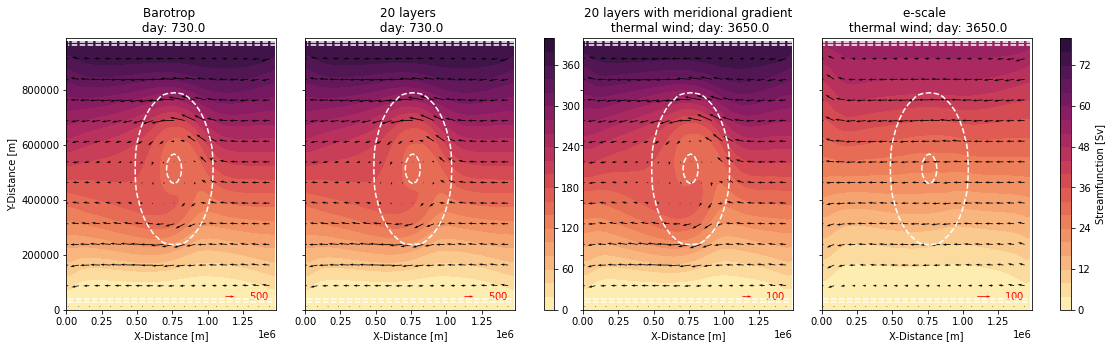

In [31]:
#plot streamfunction at last time step
wmin=0
wmax=400
lev=21
t=-1
cmap2=cmo.matter
fig,axes=plt.subplots(1,6,figsize=(18,5),gridspec_kw={'width_ratios':[1,1,0.05,1,1,0.05]})
ax=axes[0]
dsbb.psi.isel(T=t).plot.contourf(cmap=cmap2,vmin=wmin,vmax=wmax,levels=lev,ax=ax,add_colorbar=False)#cbar_kwargs={'label':''})
dsbb.Depth.plot.contour(levels=[2500,3999],ax=ax,linestyles='--',colors='w')
q=ax.quiver(dsbb.X[0:-1:arr],dsbb.Y[0:-1:arr],grid.interp(dsbb.isel(T=t,Z=0).U_baro,'X',boundary='extend')[0:-1:arr,0:-1:arr],grid.interp(dsbb.isel(T=t,Z=0).V_baro,'Y',boundary='extend')[0:-1:arr,0:-1:arr])
ax.quiverkey(q,0.8,0.05,500,label='$500$',color='r',labelpos='E',labelcolor='r',labelsep=0.2)
ax.set_title(f'Barotrop \n day: {dsbb.day.isel(T=t).values}')
ax.set_xlabel('X-Distance [m]')
ax.set_ylabel('Y-Distance [m]')
ax=axes[1]
cb=(dsb2.psi.isel(T=t)).plot.contourf(cmap=cmap2,vmin=wmin,vmax=wmax,levels=lev,ax=ax,add_colorbar=False)#cbar_kwargs={'label':''})
dsb2.Depth.plot.contour(levels=[2500,3999],ax=ax,linestyles='--',colors='w')
q=ax.quiver(dsb2.X[0:-1:arr],dsb2.Y[0:-1:arr],grid.interp(dsb2.isel(T=t,Z=0).U_baro,'X',boundary='extend')[0:-1:arr,0:-1:arr],grid.interp(dsb2.isel(T=t,Z=0).V_baro,'Y',boundary='extend')[0:-1:arr,0:-1:arr])
ax.quiverkey(q,0.8,0.05,500,label='$500$',color='r',labelpos='E',labelcolor='r',labelsep=0.2)
ax.set_title(f'20 layers \n day: {dsb2.day.isel(T=t).values}')
ax.set_xlabel('X-Distance [m]')
ax.set_ylabel('')
ax.set_yticklabels('')
plt.colorbar(cb,cax=axes[2], label='')

ax=axes[3]
(dsb2t.psi.isel(T=t)).plot.contourf(cmap=cmap2,vmin=wmin*.2,vmax=wmax*.2,levels=lev,ax=ax,add_colorbar=False)#cbar_kwargs={'label':''})
dsb2t.Depth.plot.contour(levels=[2500,3999],ax=ax,linestyles='--',colors='w')
q=ax.quiver(dsb2t.X[0:-1:arr],dsb2t.Y[0:-1:arr],grid.interp(dsb2t.isel(T=t,Z=0).U_baro,'X',boundary='extend')[0:-1:arr,0:-1:arr],grid.interp(dsb2t.isel(T=t,Z=0).V_baro,'Y',boundary='extend')[0:-1:arr,0:-1:arr])
ax.quiverkey(q,0.8,0.05,100,label='$100$',color='r',labelpos='E',labelcolor='r',labelsep=0.2)
ax.set_title(f'20 layers with meridional gradient\n thermal wind; day: {dsb2t.day.isel(T=t).values}')
ax.set_xlabel('X-Distance [m]')
ax.set_ylabel('')
ax.set_yticklabels('')

ax=axes[4]
cb=(dsbt.psi.isel(T=t)).plot.contourf(cmap=cmap2,vmin=wmin*.2,vmax=wmax*.2,levels=lev,ax=ax,add_colorbar=False)#cbar_kwargs={'label':''})
dsbt.Depth.plot.contour(levels=[2500,3999],ax=ax,linestyles='--',colors='w')
q=ax.quiver(dsbt.X[0:-1:arr],dsbt.Y[0:-1:arr],grid.interp(dsbt.isel(T=t,Z=0).U_baro,'X',boundary='extend')[0:-1:arr,0:-1:arr],grid.interp(dsbt.isel(T=t,Z=0).V_baro,'Y',boundary='extend')[0:-1:arr,0:-1:arr])
ax.quiverkey(q,0.8,0.05,100,label='$100$',color='r',labelpos='E',labelcolor='r',labelsep=0.2)
ax.set_title(f'e-scale \n thermal wind; day: {dsb2t.day.isel(T=t).values}')
ax.set_xlabel('X-Distance [m]')
ax.set_ylabel('')
ax.set_yticklabels('') 

plt.colorbar(cb,cax=axes[5], label='Streamfunction [Sv]')

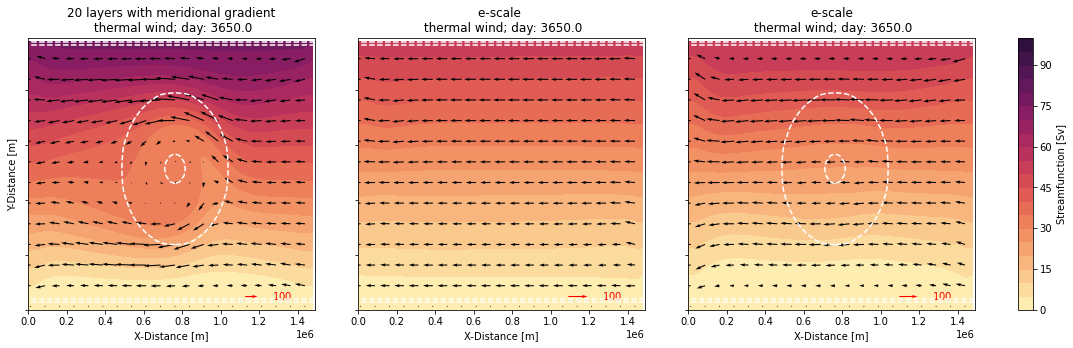

In [73]:
#plot streamfunction at last time step
wmin=0
wmax=100
lev=21
t=-1
cmap2=cmo.matter
fig,axes=plt.subplots(1,4,figsize=(18,5),gridspec_kw={'width_ratios':[1,1,1,0.05]})
ax=axes[0]
cb=(dsb2t.psi.isel(T=t)).plot.contourf(cmap=cmap2,vmin=wmin,vmax=wmax,levels=lev,ax=ax,add_colorbar=False)#cbar_kwargs={'label':''})
dsb2t.Depth.plot.contour(levels=[2500,3999],ax=ax,linestyles='--',colors='w')
q=ax.quiver(dsb2t.X[0:-1:arr],dsb2t.Y[0:-1:arr],grid.interp(dsb2t.isel(T=t,Z=0).U_baro,'X',boundary='extend')[0:-1:arr,0:-1:arr],grid.interp(dsb2t.isel(T=t,Z=0).V_baro,'Y',boundary='extend')[0:-1:arr,0:-1:arr])
ax.quiverkey(q,0.8,0.05,100,label='$100$',color='r',labelpos='E',labelcolor='r',labelsep=0.2)
ax.set_title(f'20 layers with meridional gradient\n thermal wind; day: {dsb2t.day.isel(T=t).values}')
ax.set_xlabel('X-Distance [m]')
ax.set_ylabel('Y-Distance [m]')
ax.set_yticklabels('')
ax=axes[1]
cb=(dsft.psi.isel(T=t)).plot.contourf(cmap=cmap2,vmin=wmin,vmax=wmax,levels=lev,ax=ax,add_colorbar=False)#cbar_kwargs={'label':''})
dsft.Depth.plot.contour(levels=[2500,3999],ax=ax,linestyles='--',colors='w')
q=ax.quiver(dsft.X[0:-1:arr],dsft.Y[0:-1:arr],grid.interp(dsft.isel(T=t,Z=0).U_baro,'X',boundary='extend')[0:-1:arr,0:-1:arr],grid.interp(dsft.isel(T=t,Z=0).V_baro,'Y',boundary='extend')[0:-1:arr,0:-1:arr])
ax.quiverkey(q,0.8,0.05,100,label='$100$',color='r',labelpos='E',labelcolor='r',labelsep=0.2)
ax.set_title(f'e-scale \n thermal wind; day: {dsb2t.day.isel(T=t).values}')
ax.set_xlabel('X-Distance [m]')
ax.set_ylabel('')
ax.set_yticklabels('')

ax=axes[2]
cb=(dsbt.psi.isel(T=t)).plot.contourf(cmap=cmap2,vmin=wmin,vmax=wmax,levels=lev,ax=ax,add_colorbar=False)#cbar_kwargs={'label':''})
dsbt.Depth.plot.contour(levels=[2500,3999],ax=ax,linestyles='--',colors='w')
q=ax.quiver(dsbt.X[0:-1:arr],dsbt.Y[0:-1:arr],grid.interp(dsbt.isel(T=t,Z=0).U_baro,'X',boundary='extend')[0:-1:arr,0:-1:arr],grid.interp(dsbt.isel(T=t,Z=0).V_baro,'Y',boundary='extend')[0:-1:arr,0:-1:arr])
ax.quiverkey(q,0.8,0.05,100,label='$100$',color='r',labelpos='E',labelcolor='r',labelsep=0.2)
ax.set_title(f'e-scale\n thermal wind; day: {dsb2t.day.isel(T=t).values}')
ax.set_xlabel('X-Distance [m]')
ax.set_ylabel('')
ax.set_yticklabels('')

plt.colorbar(cb,cax=axes[3], label='Streamfunction [Sv]')

Text(0, 0.5, '')

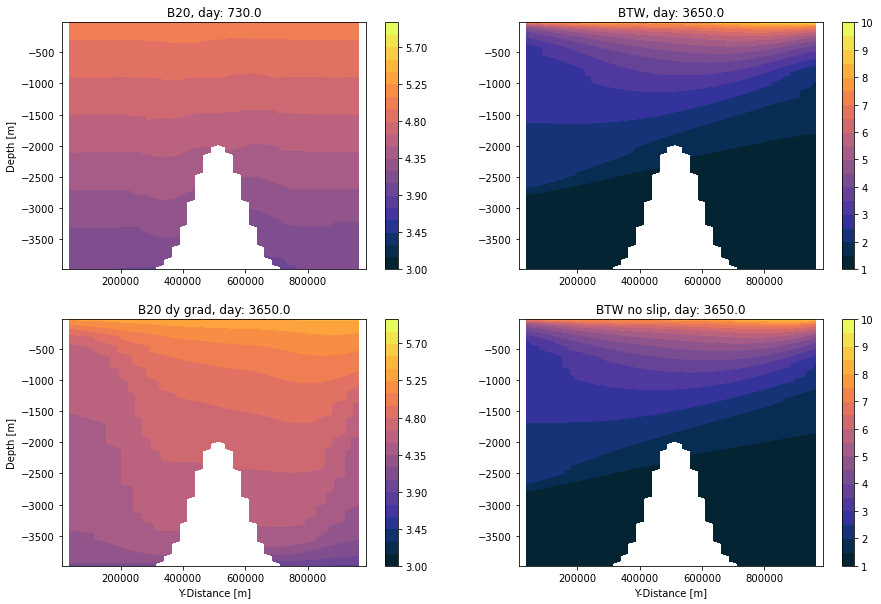

In [46]:
#plot T Section at last time step
wmax=6
wmin=3
lev=21
wmaxt=10
wmint=1
levt=19
cmap2=cmo.thermal
t=-1
fig,axes=plt.subplots(2,2,figsize=(15,10))
ax=axes[0,0]
(dsb2.Temp.where(dsb2.Temp>0).isel(T=t,X=30)).plot.contourf(cmap=cmap2,vmin=wmin,vmax=wmax,levels=lev,ax=ax,cbar_kwargs={'label':''})
ax.set_title(f'B20, day: {dsb2.day.isel(T=t).values}')
ax.set_xlabel('')
ax.set_ylabel('Depth [m]')

ax=axes[0,1]
(dsbt.Temp.where(dsbt.Temp>0).isel(T=t,X=30)).plot.contourf(cmap=cmap2,vmin=wmint,vmax=wmaxt,levels=levt,ax=ax,cbar_kwargs={'label':''})
ax.set_title(f'BTW, day: {dsbt.day.isel(T=t).values}')
ax.set_xlabel('')
ax.set_ylabel('')

ax=axes[1,0]
(dsb2t.Temp.where(dsb2t.Temp>0).isel(T=t,X=30)).plot.contourf(cmap=cmap2,vmin=wmin,vmax=wmax,levels=lev,ax=ax,cbar_kwargs={'label':''})
ax.set_title(f'B20 dy grad, day: {dsb2t.day.isel(T=t).values}')
ax.set_xlabel('Y-Distance [m]')
ax.set_ylabel('Depth [m]')

ax=axes[1,1]
(dsbts.Temp.where(dsbts.Temp>0).isel(T=t,X=30)).plot.contourf(cmap=cmap2,vmin=wmint,vmax=wmaxt,levels=levt,ax=ax,cbar_kwargs={'label':''})
ax.set_title(f'BTW no slip, day: {dsbts.day.isel(T=t).values}')
ax.set_xlabel('Y-Distance [m]')
ax.set_ylabel('')

Text(0, 0.5, '')

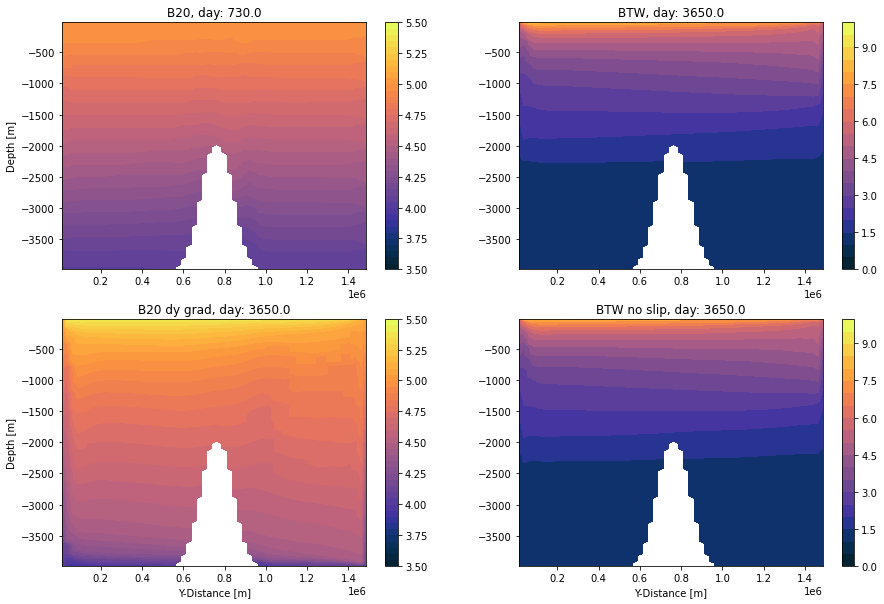

In [47]:
#plot T Section at last time step
wmax=5.5
wmin=3.5
lev=41
wmaxt=10
wmint=0
levt=21
cmap2=cmo.thermal
t=-1
fig,axes=plt.subplots(2,2,figsize=(15,10))
ax=axes[0,0]
(dsb2.Temp.where(dsb2.Temp>0).isel(T=t,Y=20)).plot.contourf(cmap=cmap2,vmin=wmin,vmax=wmax,levels=lev,ax=ax,cbar_kwargs={'label':''})
ax.set_title(f'B20, day: {dsb2.day.isel(T=t).values}')
ax.set_xlabel('')
ax.set_ylabel('Depth [m]')

ax=axes[0,1]
(dsbt.Temp.where(dsbt.Temp>0).isel(T=t,Y=20)).plot.contourf(cmap=cmap2,vmin=wmint,vmax=wmaxt,levels=levt,ax=ax,cbar_kwargs={'label':''})
ax.set_title(f'BTW, day: {dsbt.day.isel(T=t).values}')
ax.set_xlabel('')
ax.set_ylabel('')

ax=axes[1,0]
(dsb2t.Temp.where(dsb2t.Temp>0).isel(T=t,Y=20)).plot.contourf(cmap=cmap2,vmin=wmin,vmax=wmax,levels=lev,ax=ax,cbar_kwargs={'label':''})
ax.set_title(f'B20 dy grad, day: {dsb2t.day.isel(T=t).values}')
ax.set_xlabel('Y-Distance [m]')
ax.set_ylabel('Depth [m]')

ax=axes[1,1]
(dsbts.Temp.where(dsbts.Temp>0).isel(T=t,Y=20)).plot.contourf(cmap=cmap2,vmin=wmint,vmax=wmaxt,levels=levt,ax=ax,cbar_kwargs={'label':''})
ax.set_title(f'BTW no slip, day: {dsbts.day.isel(T=t).values}')
ax.set_xlabel('Y-Distance [m]')
ax.set_ylabel('')